# Preliminaries

## Libraries

In [2]:
# import sys
# sys.path = ['', '/home/linuxbrew/.linuxbrew/Cellar/python@3.9/3.9.7_1/lib/python39.zip', '/home/linuxbrew/.linuxbrew/Cellar/python@3.9/3.9.7_1/lib/python3.9', '/home/linuxbrew/.linuxbrew/Cellar/python@3.9/3.9.7_1/lib/python3.9/lib-dynload', '/home/linuxbrew/.linuxbrew/Cellar/python@3.9/3.9.7_1/lib/python3.9/site-packages', '/mnt/c/Users/crisp/Desktop/MDM3/OpenABM-Covid19-feature-spatial/src']

In [3]:
%matplotlib inline
from os.path import join
from IPython.core.display import display, HTML
import plotting

import example_utils as utils
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import networkx as nx
import ipywidgets

from shapely.ops import unary_union
import shapely.speedups
from shapely.geometry import Polygon, LineString, Point

# Graphing
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd


## Hadean Colour scheme
But feel free to choose your own.

In [4]:
# Hadean colour scheme
hadeanOrange = '#FF9448'
hadeanIndigo = '#27203B'
hadeanCoral = '#FF5C37'
hadeanCopper = '#D66444'
uranianBlue = '#AFDBF5'

In [5]:
def AddTransparency(c,a):
    b = format(max(int(255*a),0),'02X')
    return c+str(b[-2:])

## Chris' Imperial functions

In [6]:
def convert_imperial_network_edges_to_oxford_network_edges(network_data):
    network_data.rename(columns = {'a.index': 'ID_1', 'b.index': 'ID_2'}, inplace=True)
    return network_data

def convert_imperial_node_data_to_oxford_node_data(person_node_data, index_to_label_network_with):
    person_node_data.rename(columns = {'index': 'ID',
                                       'household.index': 'house_no',
                                       'age': 'age_group',
                                       'coord.x': 'x',
                                       'coord.y': 'y'}, inplace=True)

    person_node_data['network_no'] = (np.zeros(len(person_node_data)) + index_to_label_network_with)

    # Convert the age to age group (the decade age group of the person and is an integer between 0 (0-9 years) and 8 (80+).)
    person_node_data['age_group'] = person_node_data['age_group'].apply(lambda x: int(x / 10))

    #print(person_node_data) # CA remove

    return person_node_data

## Very-much-draft Coordinate functions

In [7]:
def coord2ll(x,y):
    return np.array([y,x]) * 57.2957795131

def ll2coord(long,lat):
    return np.array([lat,long]) / 57.2957795131

def coord2ll_listIn(x):
    return coord2ll(x[1],x[0])

def ll2coord_list(x):
    return ll2coord(x[1],x[0])


## Load Networks

In [8]:
##########################
# Load Network Functions #
##########################

# Take path of _nodes.csv
def LoadDemographics(demoPath):
    df_household_demographics = pd.read_csv(demoPath, comment="#", sep=",", skipinitialspace=True)
    # Converting we use network_no=0, as that's for household network
    df_household_demographics = convert_imperial_node_data_to_oxford_node_data(df_household_demographics,0)
    return df_household_demographics

def CoordsFromDemo(df_household_demographics):
    df_coordinates = df_household_demographics.rename(columns={'x':'xcoords','y':'ycoords'})[['ID','xcoords','ycoords']]
    return df_coordinates

def LoadOccupationNetworks(projPath,prefix='bristol'):
    ocNetworksArcs_df_dict = {}
    ocNetworksArcs_colNames = ['ID_1','a.x','a.y','ID_2','b.x','b.y']
    network_name = np.array(['primary', 'secondary', 'general_workforce', 'retired', 'elderly'])

    # Can find network assignment by the a.index for each _i_arcs.csv
    for i,x in enumerate(tqdm(network_name)):
        print([i,x])
        ocNetworksArcs_df_dict[x] = pd.read_csv(projPath+'/'+prefix+"_"+str(i)+"_arcs.csv", comment="#", sep=",", skipinitialspace=True)
        ocNetworksArcs_df_dict[x].columns = ocNetworksArcs_colNames
    
    return ocNetworksArcs_df_dict

###################
# Parameter stuff #
###################

def LoadParams(df_household_demographics,params=None):
    if params == None:
        params = utils.get_baseline_parameters()
    n_total = len(df_household_demographics["ID"])
    params.set_param("n_total",n_total)
    params.set_demographic_household_table(df_household_demographics)
    return params

def LoadNetworks(model,ocNetworksArcs_df_dict,daily_fration=0.5):
    for i,net in enumerate(ocNetworksArcs_df_dict):
        model.delete_network(model.get_network_by_id(i+2))
        model.add_user_network(ocNetworksArcs_df_dict[net],name=net,daily_fraction=daily_fration)

def ImperialNetwork(netPath,n_infect=10,prefix='bristol'):
    df_household_demographics = LoadDemographics(netPath+'/'+prefix+'_0_nodes.csv')
    df_coordinates = CoordsFromDemo(df_household_demographics)
    ocNetworksArcs_df_dict = LoadOccupationNetworks(netPath)
    params = LoadParams(df_household_demographics)
    params.set_param("n_seed_infection",n_infect)
    model = utils.get_simulation( params ).env.model
    model.assign_coordinates_individuals(df_coordinates)
    LoadNetworks(model,ocNetworksArcs_df_dict)
    return model

In [9]:
def LockdownInRadius(model,target,r,n=14):
    indivs = model.get_individuals()
    indivs = RadiusIndividual(model,target,r)
    t = model.one_time_step_results()['time']
    for i in indivs:
        model.intervention_quarantine_until_by_idx(i,0,t+n,0)

In [10]:
def RadiusIndividual(model,target,r,d=np.linalg.norm):
    x = model.get_individuals()
    x['d'] = d(x[['xcoords','ycoords']]-target,axis=1)
    x = x.loc[x['d']<=r]
    return list(x['ID'])

# Visualise Network

In [11]:
statuses2Track = [1,2,3,4,5,6,7,8,20] # In model.py, v. difficult to find
statuses2Track = [4,5]

def Infected(model):
    x = model.get_individuals()
    x = x.loc[x['current_status'].isin(statuses2Track)]
    return list(x['ID'])

In [12]:
# scarrily current_status does not seem to change when quarantined
def Lockdowned(model):
    x = model.get_individuals()
    x = x.loc[x['quarantined'] == 1]
    return list(x['ID'])

In [13]:
def VisualiseNetwork(model,ax,aNode = 1/2**7,aEdge = 1/2**7):
    # Correct function!
    nodes = model.get_individuals()
    nodes_pos = {nodes['ID'][i]:[nodes['xcoords'][i],nodes['ycoords'][i]] for i in range(len(nodes))}
    infected = Infected(model)
    quarantined = Lockdowned(model)
    g = nx.Graph()
    #g = nx.from_pandas_edgelist(ocNetworksArcs_df_dict['primary'],'ID_1','ID_2',create_using=nx.Graph())
    g.add_nodes_from(nodes['ID'])
    g_infected = nx.subgraph(g,infected)
    g_quarantined = nx.subgraph(g,quarantined)
    #f,ax = plt.subplots(figsize=(20,10))
    nx.draw(g,pos=nodes_pos,node_size=5,edge_color=AddTransparency(hadeanOrange,aEdge),node_color=AddTransparency(hadeanIndigo,aNode),ax=ax)
    nx.draw_networkx_nodes(g_quarantined,pos=nodes_pos,node_size=5,node_color=AddTransparency(uranianBlue,0.02),ax=ax)
    nx.draw_networkx_nodes(g_infected,pos=nodes_pos,node_size=5,node_color=AddTransparency(hadeanOrange,0.9),ax=ax)

In [14]:
bristol_net_dir = "../../id_spatial_sim/scenarios/bristol/output/networks"
mdm_net_dir = "../../id_spatial_sim/scenarios/mdm3_scenario/output/networks"
# test_model = ImperialNetwork(bristol_net_dir)
# f,ax = plt.subplots(figsize=(20,10))
# VisualiseNetwork(test_model,ax)

In [15]:
n = 128
aNode = 1/2**7
aEdge = 1/2**7
bristol_gif_out = '../../NetworkData/bristol/'
mdm_gif_out = '../../NetworkData/mdm/'
gif_out = '../../NetworkData/'

In [16]:
from matplotlib.lines import Line2D

# Run several time-steps and produce many PNGs to be converted to a GIF
def RunSim(model, out_dir=gif_out, n=64, title_text='Spread of COVID-19 on an artificial network of Bristol'):
    for i in tqdm(range(n)):
        f,ax = plt.subplots(figsize=(20,10))
        t = model.one_time_step_results()['time']
        #VisualiseNetwork(model,ax)
        plt.title(title_text,fontsize=32)
        agentPatch = Line2D([0],[0],marker='o',linestyle='none',color=AddTransparency(hadeanIndigo,aNode),label='Agent')
        conPatch = Line2D([0],[0],marker='o',linestyle='none',color=AddTransparency(hadeanOrange,0.9),label='Contagious')
        lg1 = plt.legend(handles=[agentPatch,conPatch],fontsize=16)
        text = "Time = "+"{:04d}".format(t)
        textPatch = Line2D([0],[0],linestyle='none',label=text)
        ax.legend(handles=[textPatch],loc='lower left',frameon=False)
        ax.add_artist(lg1)
        print(out_dir+"{:04d}".format(t)+'.png')
        f.savefig(out_dir+"{:04d}".format(t)+'.png')
        model.one_time_step()
        ax.clear()
        plt.clf()
    
# Then use a `convert ./out_dir/*.png ./net.gif` from terminal

# Seeding
For the Hotwells/Bristol.

In [33]:
# replace bc4 with the coords of your desired location
long,lat = coord2ll(1.0,-.1)
x,y = ll2coord(long,lat)

# ASSL coords
bc4 = [51.45951819, -2.60148918]
bc4_x, bc4_y = ll2coord(bc4[0],bc4[1])
bc4_xy = np.array([bc4_x,bc4_y])
# print([bc4_x, bc4_y])



bristol_model = ImperialNetwork(bristol_net_dir)
bristol_df_indiv = bristol_model.get_individuals()
print("\nBristol model generated. \n")

mdm_model = ImperialNetwork(mdm_net_dir)
mdm_df_indiv = mdm_model.get_individuals()
print("\nMDM model generated. \n")



d = np.linalg.norm
bristol_df_indiv['d'] = d(bristol_df_indiv[['xcoords','ycoords']]-bc4_xy,axis=1)
mdm_df_indiv['d'] = d(mdm_df_indiv[['xcoords','ycoords']]-bc4_xy,axis=1)



bristol_mind = bristol_df_indiv['d'].idxmin()
bristol_bc4_house = int(bristol_df_indiv.iloc[bristol_mind]['house_no'])
# print(bristol_df_indiv.iloc[bristol_mind])
# print(coord2ll(bristol_df_indiv.iloc[bristol_mind]['xcoords'],bristol_df_indiv.iloc[bristol_mind]['ycoords']))

print('\n')

mdm_mind = mdm_df_indiv['d'].idxmin()
mdm_bc4_house = int(mdm_df_indiv.iloc[mdm_mind]['house_no'])
# print(mdm_df_indiv.iloc[mdm_mind])
# print(coord2ll(mdm_df_indiv.iloc[mdm_mind]['xcoords'],mdm_df_indiv.iloc[mdm_mind]['ycoords']))



coord2ll(bristol_df_indiv.iloc[bristol_mind]['xcoords'],bristol_df_indiv.iloc[bristol_mind]['ycoords'])
coord2ll(mdm_df_indiv.iloc[mdm_mind]['xcoords'],mdm_df_indiv.iloc[mdm_mind]['ycoords'])



bristol_df_indiv.loc[bristol_df_indiv['house_no']==bristol_bc4_house]
mdm_df_indiv.loc[mdm_df_indiv['house_no']==mdm_bc4_house]




bristol_bc4_indivs = [x for x in list(bristol_df_indiv.loc[bristol_df_indiv['house_no']==bristol_bc4_house]['ID'])]
mdm_df_indiv = [x for x in list(mdm_df_indiv.loc[mdm_df_indiv['house_no']==mdm_bc4_house]['ID'])]



for i in bristol_bc4_indivs:
    bristol_model.seed_infect_by_idx(i)
    
for i in mdm_df_indiv:
    mdm_model.seed_infect_by_idx(i)

  0%|          | 0/5 [00:00<?, ?it/s]

[0, 'primary']
[1, 'secondary']
[2, 'general_workforce']
[3, 'retired']
[4, 'elderly']

Bristol model generated. 



  0%|          | 0/5 [00:00<?, ?it/s]

[0, 'primary']
[1, 'secondary']
[2, 'general_workforce']
[3, 'retired']
[4, 'elderly']

MDM model generated. 





In [34]:
m = 100 - 20

Lockdowned(bristol_model)
RadiusIndividual(bristol_model,bc4_xy,.00001)
ev = [51.44930383152205, -2.619099290387059]

r2halfkm = np.linalg.norm(np.array(ll2coord(bc4[0],bc4[1]))-np.array(ll2coord(ev[0],ev[1]))) #3.5km
# print(r2halfkm)

# RunSim(bristol_model,n=40, out_dir=bristol_gif_out)
# LockdownInRadius(bristol_model, bc4_xy, r2halfkm*30, n=14)
# RunSim(bristol_model,n = 50, out_dir=bristol_gif_out)


RunSim(bristol_model, n=m, out_dir=bristol_gif_out)
RunSim(mdm_model, n=m, out_dir=mdm_gif_out)

  0%|          | 0/80 [00:00<?, ?it/s]

../../NetworkData/bristol/0000.png
../../NetworkData/bristol/0001.png
../../NetworkData/bristol/0002.png
../../NetworkData/bristol/0003.png
../../NetworkData/bristol/0004.png
../../NetworkData/bristol/0005.png
../../NetworkData/bristol/0006.png
../../NetworkData/bristol/0007.png
../../NetworkData/bristol/0008.png
../../NetworkData/bristol/0009.png
../../NetworkData/bristol/0010.png
../../NetworkData/bristol/0011.png
../../NetworkData/bristol/0012.png
../../NetworkData/bristol/0013.png
../../NetworkData/bristol/0014.png
../../NetworkData/bristol/0015.png
../../NetworkData/bristol/0016.png
../../NetworkData/bristol/0017.png
../../NetworkData/bristol/0018.png
../../NetworkData/bristol/0019.png


/tmp/ipykernel_739/1791490980.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax = plt.subplots(figsize=(20,10))


../../NetworkData/bristol/0020.png
../../NetworkData/bristol/0021.png
../../NetworkData/bristol/0022.png
../../NetworkData/bristol/0023.png
../../NetworkData/bristol/0024.png
../../NetworkData/bristol/0025.png
../../NetworkData/bristol/0026.png
../../NetworkData/bristol/0027.png
../../NetworkData/bristol/0028.png
../../NetworkData/bristol/0029.png
../../NetworkData/bristol/0030.png
../../NetworkData/bristol/0031.png
../../NetworkData/bristol/0032.png
../../NetworkData/bristol/0033.png
../../NetworkData/bristol/0034.png
../../NetworkData/bristol/0035.png
../../NetworkData/bristol/0036.png
../../NetworkData/bristol/0037.png
../../NetworkData/bristol/0038.png
../../NetworkData/bristol/0039.png
../../NetworkData/bristol/0040.png
../../NetworkData/bristol/0041.png
../../NetworkData/bristol/0042.png
../../NetworkData/bristol/0043.png
../../NetworkData/bristol/0044.png
../../NetworkData/bristol/0045.png
../../NetworkData/bristol/0046.png
../../NetworkData/bristol/0047.png
../../NetworkData/br

  0%|          | 0/80 [00:00<?, ?it/s]

../../NetworkData/mdm/0000.png
../../NetworkData/mdm/0001.png
../../NetworkData/mdm/0002.png
../../NetworkData/mdm/0003.png
../../NetworkData/mdm/0004.png
../../NetworkData/mdm/0005.png
../../NetworkData/mdm/0006.png
../../NetworkData/mdm/0007.png
../../NetworkData/mdm/0008.png
../../NetworkData/mdm/0009.png
../../NetworkData/mdm/0010.png
../../NetworkData/mdm/0011.png
../../NetworkData/mdm/0012.png
../../NetworkData/mdm/0013.png
../../NetworkData/mdm/0014.png
../../NetworkData/mdm/0015.png
../../NetworkData/mdm/0016.png
../../NetworkData/mdm/0017.png
../../NetworkData/mdm/0018.png
../../NetworkData/mdm/0019.png
../../NetworkData/mdm/0020.png
../../NetworkData/mdm/0021.png
../../NetworkData/mdm/0022.png
../../NetworkData/mdm/0023.png
../../NetworkData/mdm/0024.png
../../NetworkData/mdm/0025.png
../../NetworkData/mdm/0026.png
../../NetworkData/mdm/0027.png
../../NetworkData/mdm/0028.png
../../NetworkData/mdm/0029.png
../../NetworkData/mdm/0030.png
../../NetworkData/mdm/0031.png
../../Ne

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [35]:
###################
# Crispian's Mods #
###################

# to change:
# params.set_param('relative_transmission_random',0)


## Write bristol output files
bristol_df_timeseries = pd.DataFrame(bristol_model.results)
bristol_model.write_output_files()
# Rename and move bristol output files into subfolder
os.rename("individual_file_Run1.csv", "./output_files/bristol_individual_file_Run1.csv")
os.rename("interactions_Run1.csv", "./output_files/bristol_interactions_Run1.csv")
os.rename("trace_tokens_Run1.csv", "./output_files/bristol_trace_tokens_Run1.csv")
os.rename("transmission_Run1.csv", "./output_files/bristol_transmission_Run1.csv")


## Write mdm3 output files
mdm_df_timeseries = pd.DataFrame(mdm_model.results)
mdm_model.write_output_files()
# Rename and move mdm3 output files into subfolder
os.rename("individual_file_Run1.csv", "./output_files/mdm_individual_file_Run1.csv")
os.rename("interactions_Run1.csv", "./output_files/mdm_interactions_Run1.csv")
os.rename("trace_tokens_Run1.csv", "./output_files/mdm_trace_tokens_Run1.csv")
os.rename("transmission_Run1.csv", "./output_files/mdm_transmission_Run1.csv")



In [36]:
# Read files
# Read bristol output files
bristol_df_indiv = pd.read_csv(join("./output_files/bristol_individual_file_Run1.csv"))
bristol_df_interact = pd.read_csv(join("./output_files/bristol_interactions_Run1.csv"))
bristol_df_trans = pd.read_csv(join("./output_files/bristol_transmission_Run1.csv"))
# Read mdm3 output files
mdm_df_indiv = pd.read_csv(join("./output_files/mdm_individual_file_Run1.csv"))
mdm_df_interact = pd.read_csv(join("./output_files/mdm_interactions_Run1.csv"))
mdm_df_trans = pd.read_csv(join("./output_files/mdm_transmission_Run1.csv"))

In [37]:
# Export Timeseries Data

bristol_df_timeseries.to_csv('bristol_df_timeseries.csv', encoding='utf-8')
mdm_df_timeseries.to_csv('mdm_df_timeseries.csv', encoding='utf-8')


# print(mdm_df_indiv) #17 categories
# print(mdm_df_interact) #15 categories
# print(mdm_df_trans) #35 categories

In [17]:
# bc4 = [50.75328904, -1.55764306]
# bc4_x, bc4_y = ll2coord(bc4[0],bc4[1])
# bc4_xy = np.array([bc4_x,bc4_y])
# print(bc4)
# print(bc4_xy)

In [18]:
# d = np.linalg.norm
# df_indiv['d'] = d(df_indiv[['xcoords','ycoords']]-bc4_xy,axis=1)
# mind = df_indiv['d'].idxmin()
# print(mind)
# bc4_house = int(df_indiv.iloc[mind]['house_no'])
# print(bc4_house)

In [20]:
# Lockdowned(model)

In [21]:
# bc4_indivs[-1]

In [22]:
# RadiusIndividual(model,bc4_xy,.00001)

In [23]:
ev = [50.74722149271622, -1.5903702505310746]

In [24]:
bc4

[51.44930034, -2.61915242]

In [25]:
r2halfkm = np.linalg.norm(np.array(ll2coord(bc4[0],bc4[1]))-np.array(ll2coord(ev[0],ev[1]))) #3.5km
r2halfkm

0.021738336545536988

In [26]:
len(RadiusIndividual(bristol_model,bc4_xy,r2halfkm))

620000

In [28]:
# # GIF without local lockdown
# model = ImperialNetwork()
# for i in bc4_indivs:
#     model.seed_infect_by_idx(i)
# RunSim(model,n=64)

In [42]:
# # GIF WITH local lockdown
# def lockdownGIF(input_model_path, gif_out = '../../NetworkData/')
    
#     model = ImperialNetwork(input_model_path)
#     for i in bc4_indivs:
#         model.seed_infect_by_idx(i)
#     RunSim(model,out_dir=gif_out,n=6)
#     LockdownInRadius(model,bc4_xy,r2halfkm*2,n=21)
#     RunSim(model,out_dir=gif_out,n=64-6)

In [31]:
### Following Cells are For Plotting from the Extended Output notebook ###

# Time series <a class="anchor" id="time-series"></a>
[[Home](#home)]

Plot the epidemic trajectory and other outputs from the time series file for a single parameter set.  

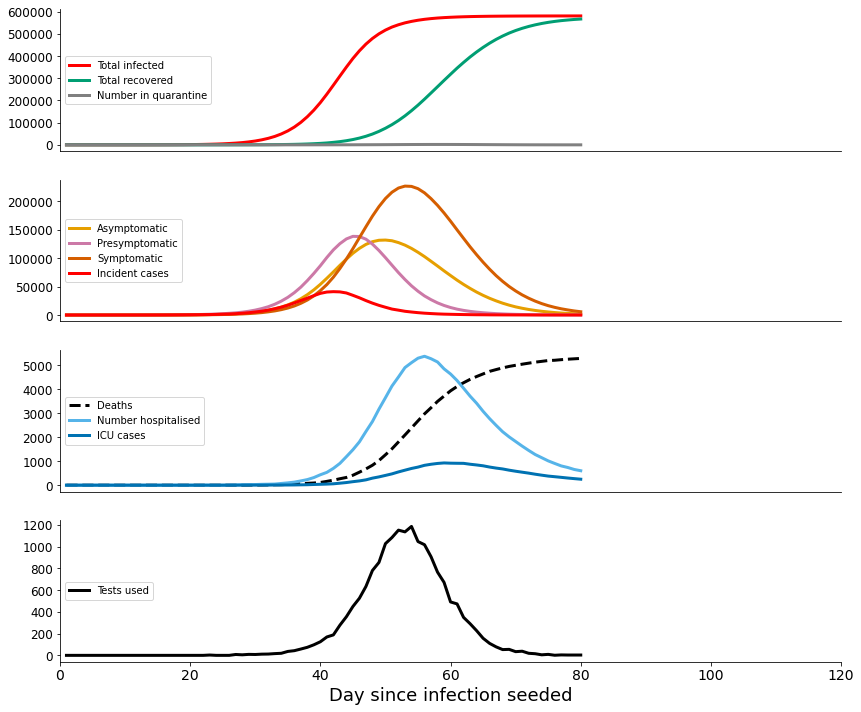

In [38]:
# bristol scenario time series plot
plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plotting.plot_timeseries_curves(bristol_df_timeseries, xlimits = [0, 120])

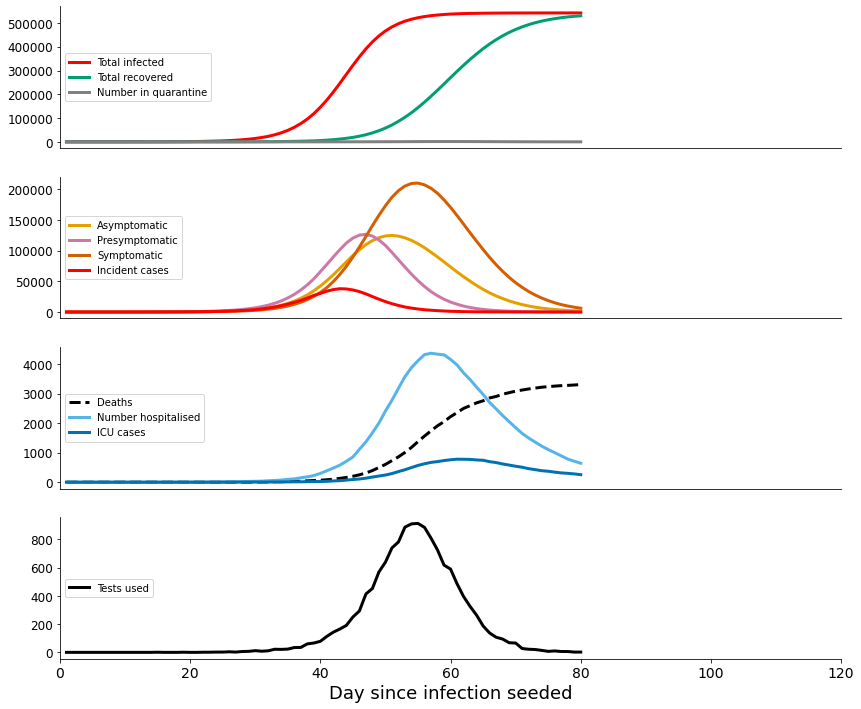

In [39]:
# mdm scenario time series plot
plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plotting.plot_timeseries_curves(mdm_df_timeseries, xlimits = [0, 120])

In [30]:
from COVID19.model import AgeGroupEnum, EVENT_TYPES, TransmissionTypeEnum, OccupationNetworkEnum

interaction_types = [c.value for c in TransmissionTypeEnum ]
interaction_labels = [c.name[1:].title() for c in TransmissionTypeEnum]

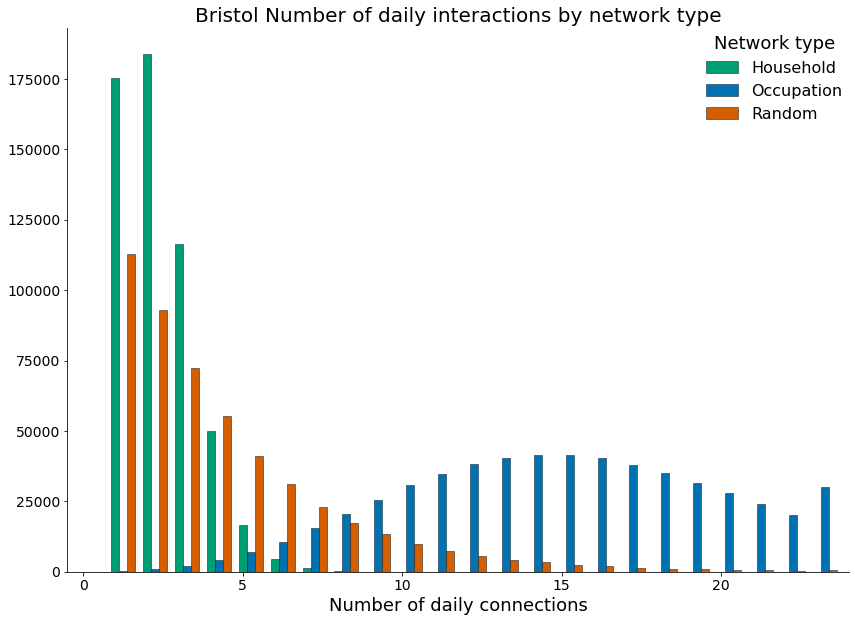

In [31]:
plt.rcParams['figure.figsize'] = [14, 10]
# Count interactions for each individual by "type" of interaction
df_agg = bristol_df_interact.groupby(["ID_1", "type"])["ID_1"].count().reset_index(name = "count")

# Plot histogram of interaction by network type
fig, ax = plotting.plot_hist_by_group(df_agg, groupvar = "type", binvar = "count", 
    groups = interaction_types, bins = 25, group_colours = plotting.network_colours, 
    group_labels = interaction_labels, 
    xlabel = "Number of daily connections", 
    title = "Bristol Number of daily interactions by network type", 
    legend_title = "Network type")

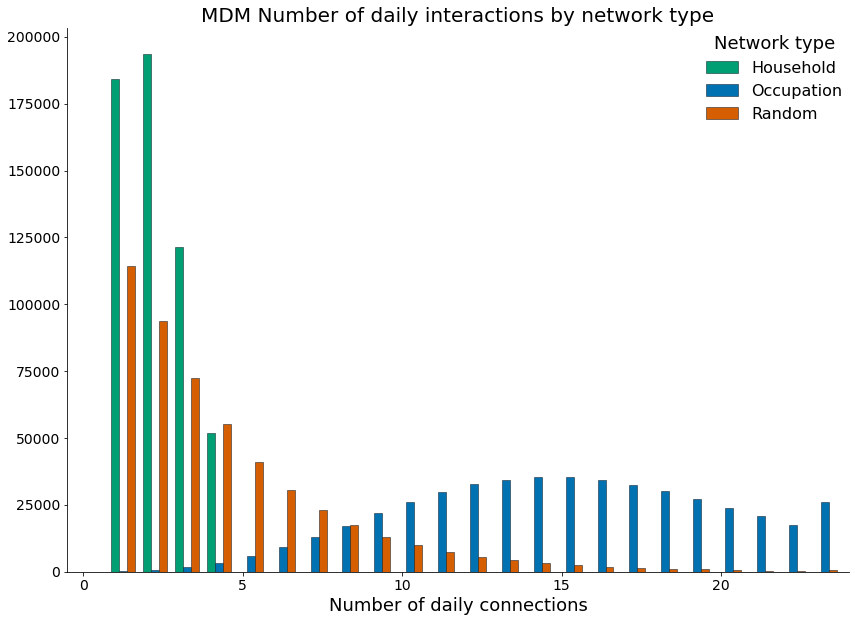

In [32]:
plt.rcParams['figure.figsize'] = [14, 10]
# Count interactions for each individual by "type" of interaction
df_agg = mdm_df_interact.groupby(["ID_1", "type"])["ID_1"].count().reset_index(name = "count")

# Plot histogram of interaction by network type
fig, ax = plotting.plot_hist_by_group(df_agg, groupvar = "type", binvar = "count", 
    groups = interaction_types, bins = 25, group_colours = plotting.network_colours, 
    group_labels = interaction_labels, 
    xlabel = "Number of daily connections", 
    title = "MDM Number of daily interactions by network type", 
    legend_title = "Network type")